In [3]:
%matplotlib notebook

from keras.datasets import mnist
import numpy as np
from keras.models import Sequential, Model
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import BatchNormalization, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Reshape, Dropout, Flatten, Input, Dense, multiply
from keras.optimizers import Adam
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

heigth = x_train.shape[-2]
width = x_train.shape[-1]

x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)
y_train = y_train.reshape(-1, 1)    
input_shape = (heigth, width, 1)
classes = 10
    
generator_noise_size = 100

In [4]:
def discrimantor():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), input_shape=input_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.35))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.35))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.35))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.35))

    model.add(Flatten())
    
    input_data = Input(shape=input_shape) 

    model_tensor = model(inputs=input_data)
    is_real = Dense(1, activation="sigmoid")(model_tensor)
    output_label = Dense(classes + 1, activation="softmax")(model_tensor)

    final_model = Model(input_data, [is_real, output_label])
    final_model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], 
                        optimizer=Adam(0.0002, 0.5),
                        metrics=['accuracy'])
    final_model.trainable = False
    return final_model


In [5]:
def generator():
    model = Sequential()
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=generator_noise_size))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())

    model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())

    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(1, kernel_size=(3, 3), padding='same', activation="tanh"))
    
    input_noise = Input(shape=(generator_noise_size,))
    input_label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(classes, generator_noise_size)(input_label))

    model_input = multiply([input_noise, label_embedding])
    model_output = model(model_input)

    final_model = Model([input_noise, input_label], model_output)
    return final_model

In [6]:
generator_model = generator()
discrimantor_model = discrimantor()

random_noise = Input(shape=(generator_noise_size,))
noise_label = Input(shape=(1,))
image_output = generator_model([random_noise, noise_label])

#	check upon the generator
valid, valid_label = discrimantor_model(image_output)

combined = Model([random_noise, noise_label], [valid, valid_label])
combined.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], 
                      optimizer=Adam(0.0002, 0.5))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


<IPython.core.display.Javascript object>


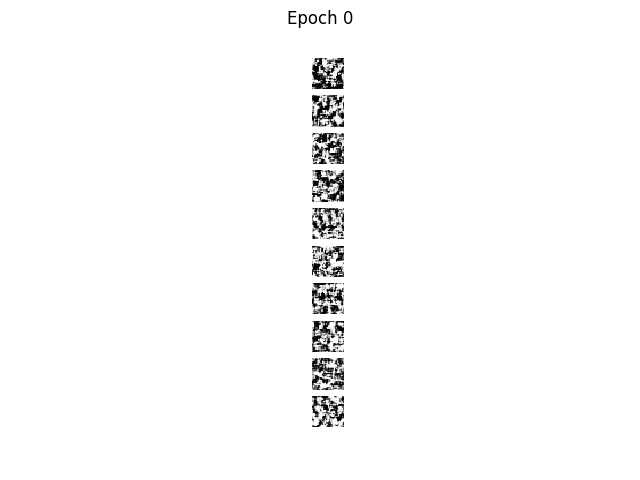

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Instructions for updating:
Use tf.cast instead.


In [7]:
figure, axes = plt.subplots(10)
plt.ion()

figure.show()
figure.canvas.draw()

batch_size = 64
for epoch in range(1000):
    indices = np.random.randint(0, x_train.shape[0], batch_size)
    image, image_label = x_train[indices], y_train[indices]

    random_noise = np.random.normal(0, 1, (batch_size, generator_noise_size))
    random_labels = np.random.randint(0, 10, (batch_size, 1))

    generated_images = generator_model.predict([random_noise, random_labels])

    input_real = np.ones((batch_size, 1))
    discrimantor_model.train_on_batch(image, [input_real, image_label])

    input_fake = np.zeros((batch_size, 1))
    labels_fake = 10 * np.ones(image_label.shape)
    discrimantor_model.train_on_batch(generated_images, [input_fake, labels_fake])

    combined.train_on_batch([random_noise, random_labels], [input_real, random_labels])

    figure.suptitle("Epoch {}".format(epoch))
    random_noise = np.random.normal(0, 1, (10, generator_noise_size))
    noise_labels = np.array(list(range(10)))

    images = generator_model.predict([random_noise, noise_labels])
    images = 0.5 * images + 0.5

    for index in range(10):
        axes[index].imshow(images[index, :, :, 0], cmap='gray')
        axes[index].axis('off')
    figure.canvas.draw()
    plt.savefig('/root/photo/{}.png'.format(epoch)) 